In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [2]:
lat = {}
lon = {}

lat['Katherine'] = -14.5
lon['Katherine'] = 132.3

lat['Surat'] = -27.2
lon['Surat'] = 149.1

lat['Miena'] = -42.0
lon['Miena'] = 146.7

In [3]:
location = 'Miena'

### Observations

In [4]:
rx1day_obs_file = '/Users/irv033/Desktop/unseen-bias/rx1day_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'

In [5]:
ds_obs = fileio.open_dataset(rx1day_obs_file)

In [6]:
da_obs = ds_obs['pr'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [7]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [8]:
df_obs = da_obs.to_dataframe()

In [9]:
ranked_years = df_obs.sort_values(by='pr', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time         pr
time                                                   
1946-06-30 00:00:00 -42.0  146.5  1946-02-19  87.910278
1929-06-30 00:00:00 -42.0  146.5  1929-04-05  78.879562
1960-06-30 00:00:00 -42.0  146.5  1960-04-23  76.770493
2016-06-30 00:00:00 -42.0  146.5  2016-06-06  72.683517
1915-06-30 00:00:00 -42.0  146.5  1915-04-12  67.631607
1908-06-30 00:00:00 -42.0  146.5  1907-12-27  59.754547
1938-06-30 00:00:00 -42.0  146.5  1938-02-05  58.033943
1999-06-30 00:00:00 -42.0  146.5  1998-12-27  57.214817
1931-06-30 00:00:00 -42.0  146.5  1931-03-03  51.931149
1916-06-30 00:00:00 -42.0  146.5  1916-01-30  51.755730


In [10]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [11]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [12]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

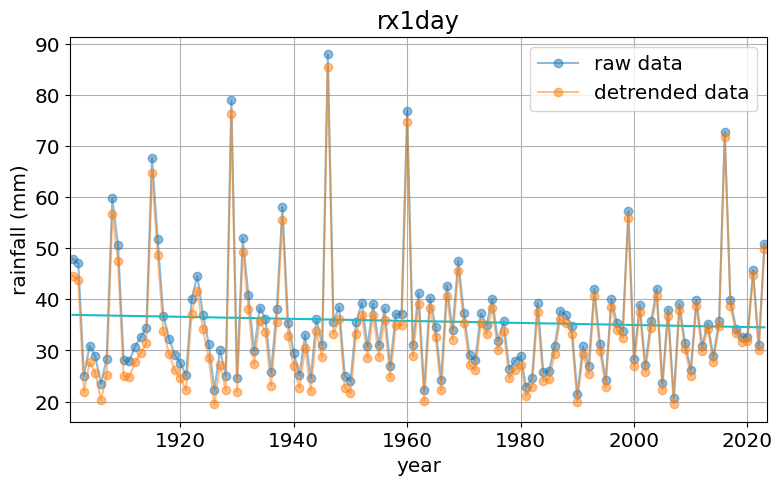

In [13]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('rx1day')
plt.ylabel('rainfall (mm)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [14]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: -0.19
Location parameter: 28.19
Scale parameter: 6.87


### Model data

In [15]:
rx1day_model_file = '/Users/irv033/Desktop/unseen-bias/rx1day_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'

In [16]:
ds_model = fileio.open_dataset(rx1day_model_file)

In [17]:
da_model = ds_model['pr'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [18]:
da_model = da_model.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [19]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [21]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [22]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [23]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [24]:
da_model_detrended = da_model_detrended_stacked.unstack()

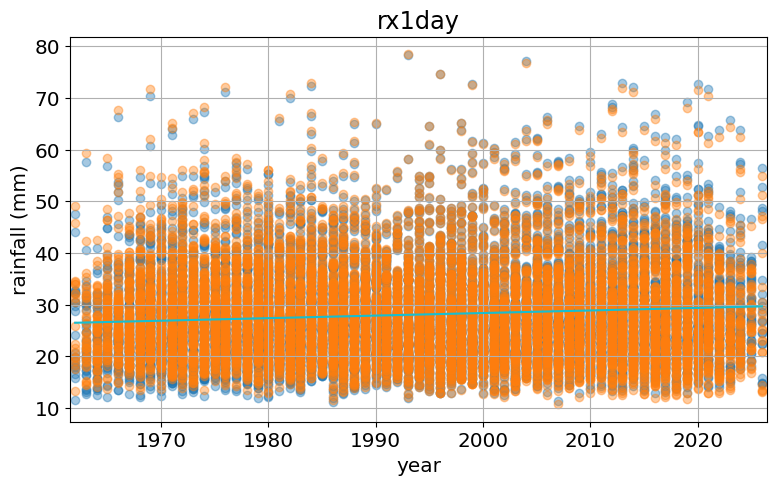

In [25]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('rx1day')
plt.ylabel('rainfall (mm)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


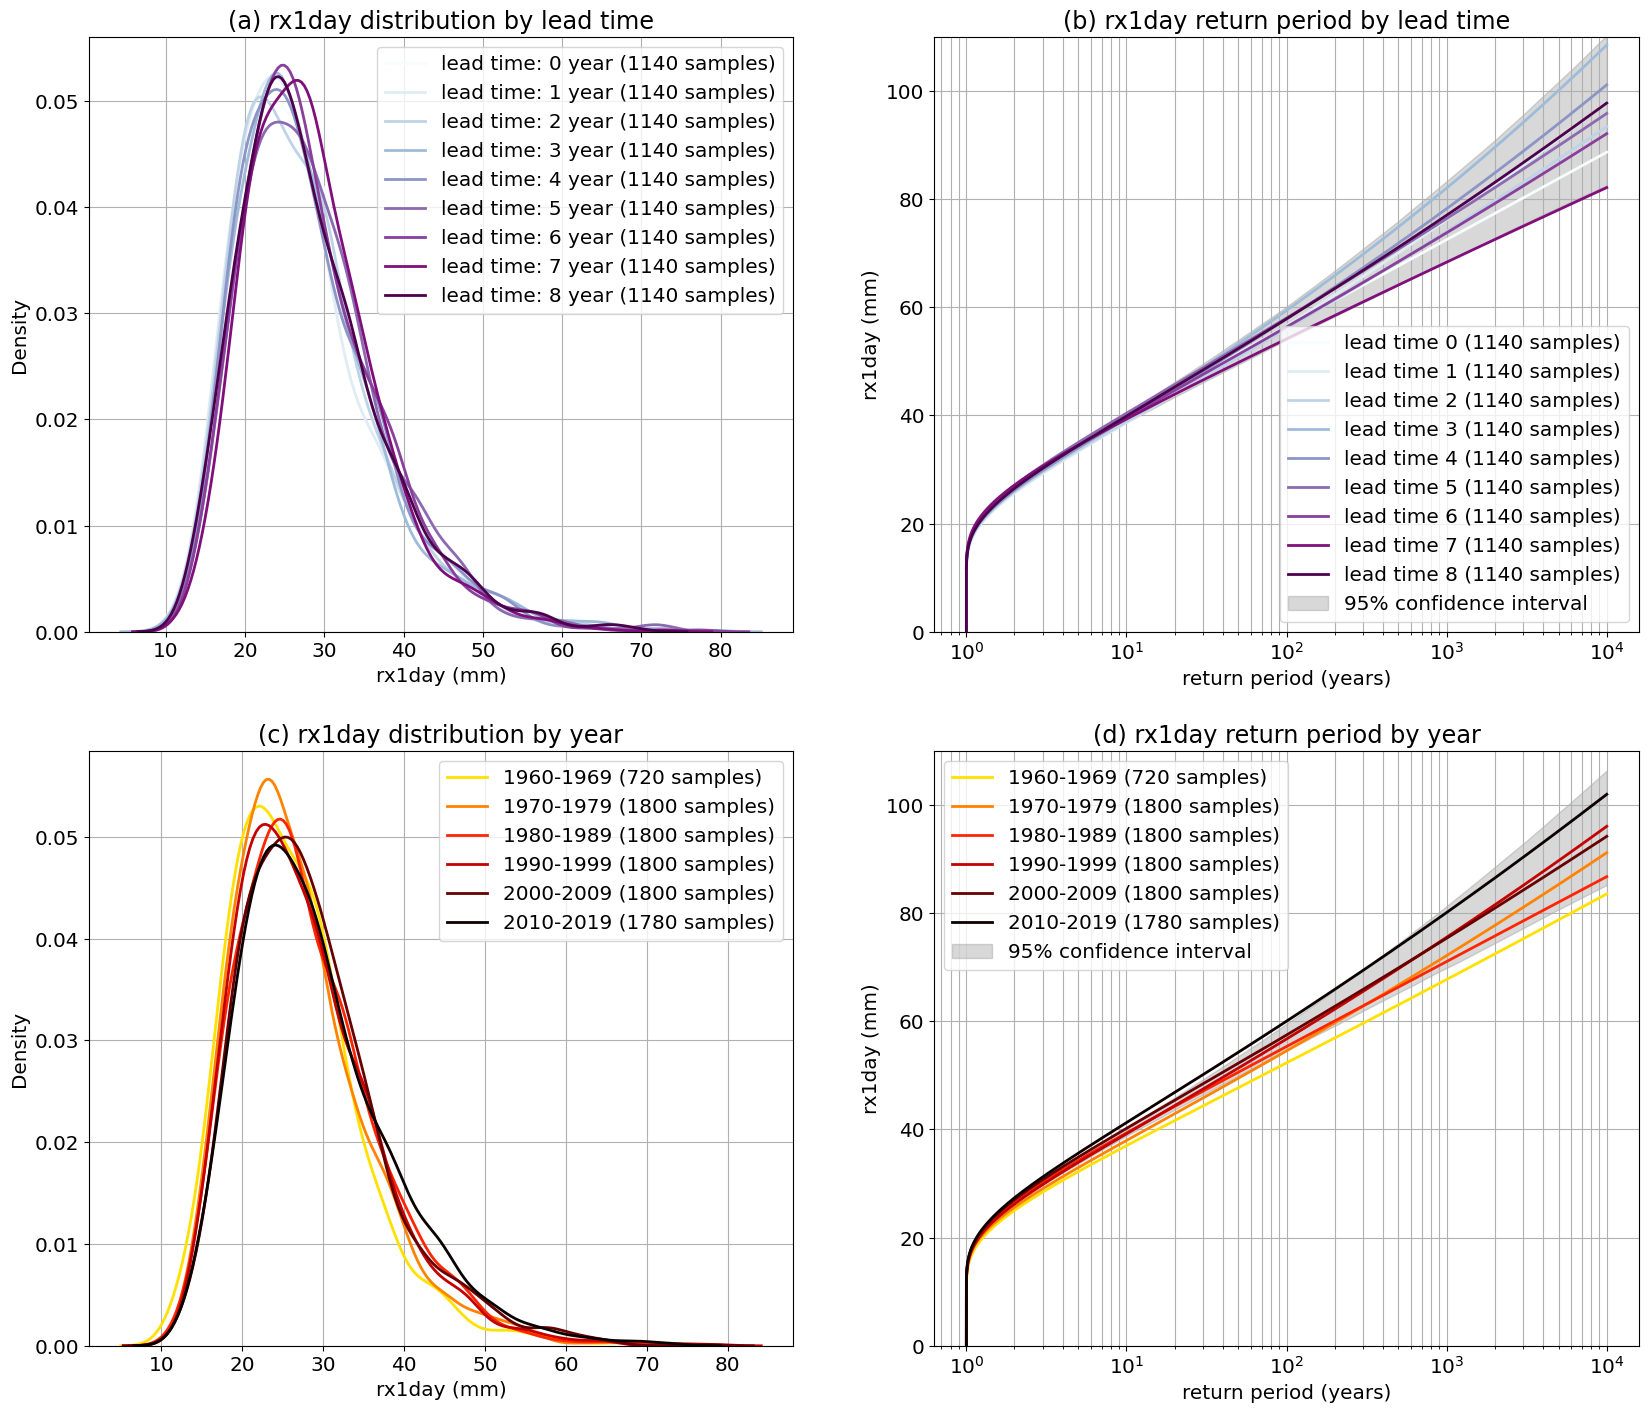

In [68]:
stability.create_plot(
    da_model,
    'rx1day',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='rx1day (mm)',
    ylim=(0, 110),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


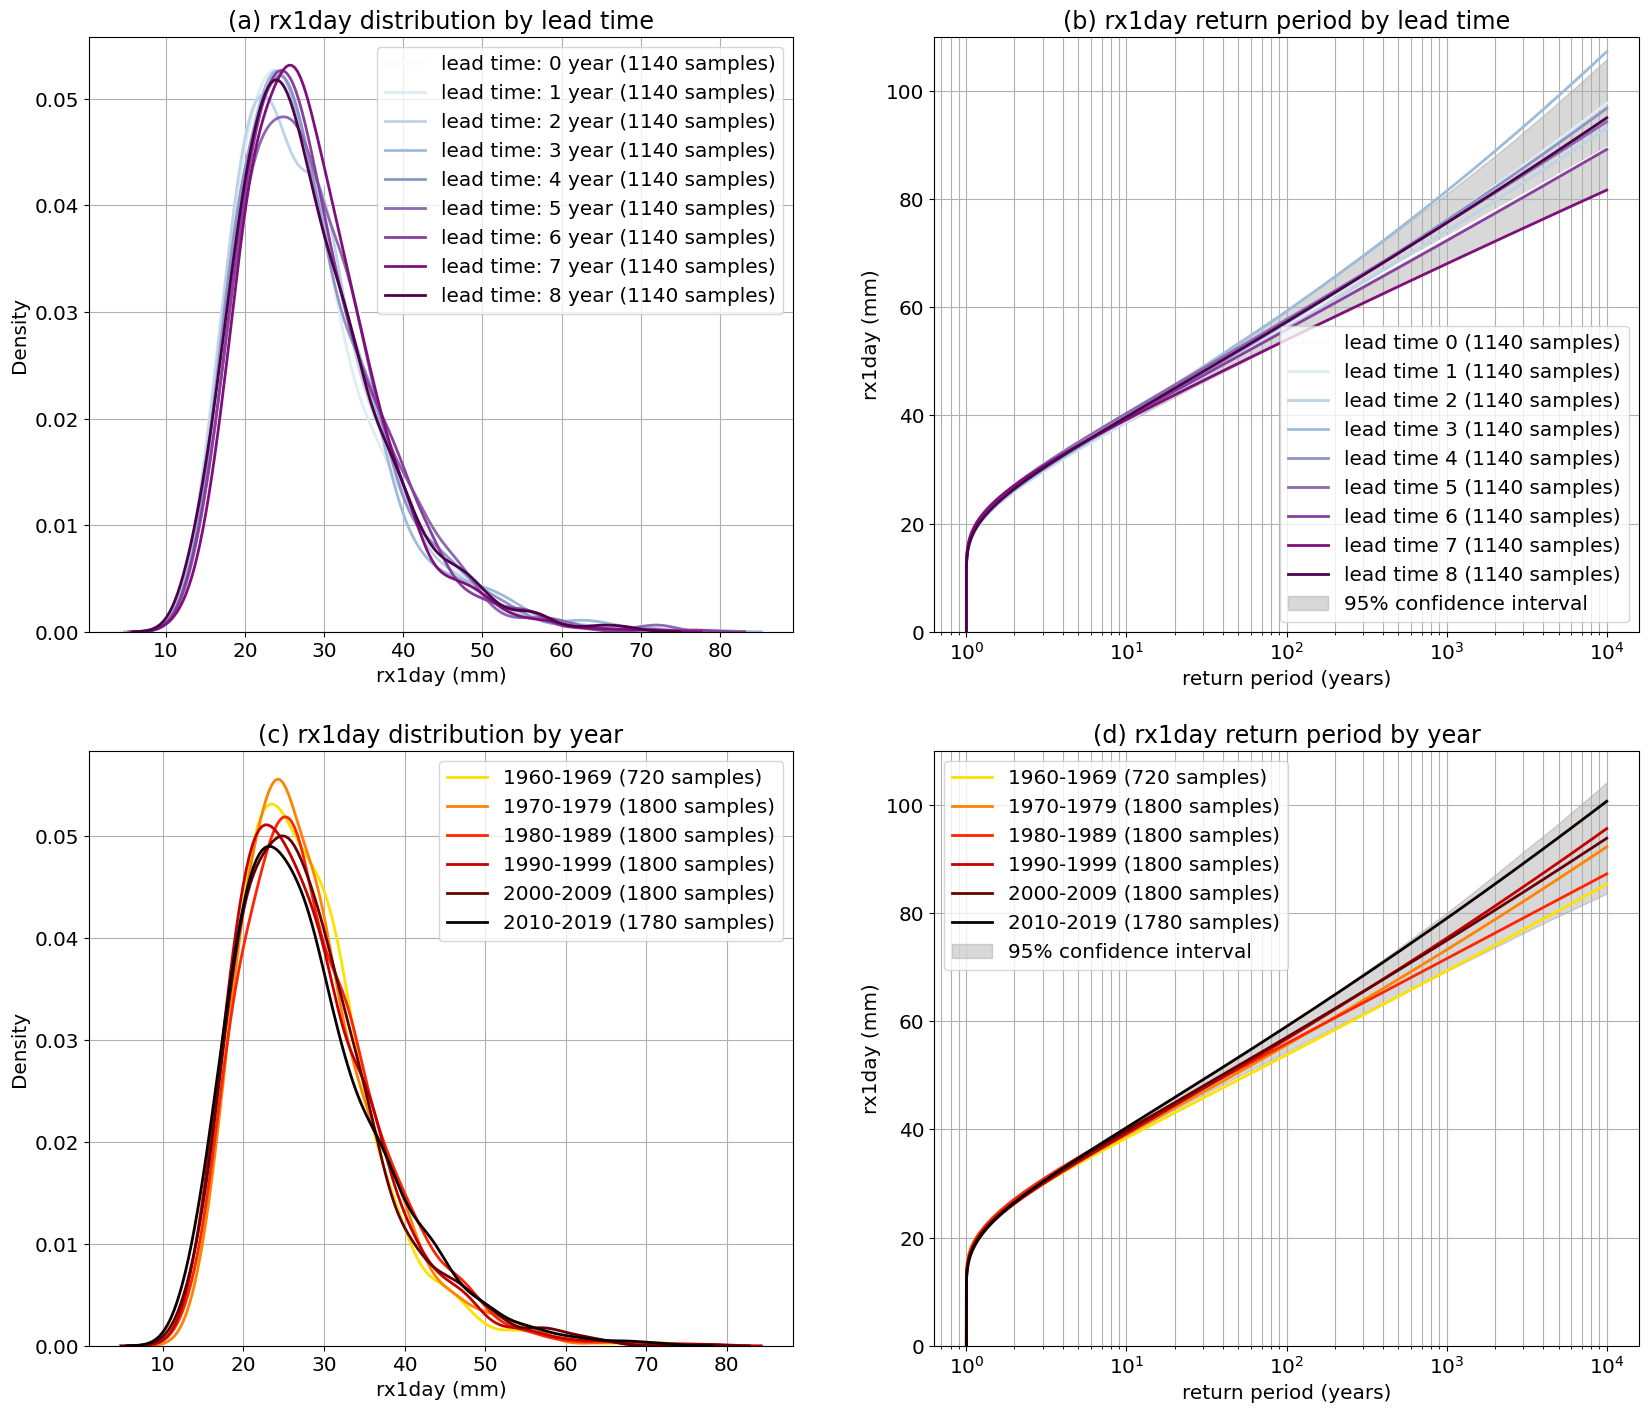

In [70]:
stability.create_plot(
    da_model_detrended,
    'rx1day',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='rx1day (mm)',
    ylim=(0, 110),
)

In [28]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: -0.02
Location parameter: 24.14
Scale parameter: 6.69


### Mean correction

#### Additive

In [29]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [30]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [31]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [32]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack(
    {'sample': ['ensemble', 'init_date', 'lead_time']}
)

In [33]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: -0.02
Location parameter: 28.13
Scale parameter: 6.69


#### Multiplicative

In [34]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [35]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'multiplicative')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [36]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack(
    {'sample': ['ensemble', 'init_date', 'lead_time']}
)

In [37]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: -0.02
Location parameter: 27.55
Scale parameter: 7.63


### Quantile correction

In [38]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [39]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [40]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)
# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [41]:
da_model_detrended_q.values

array([16.90484561, 19.73691454, 21.89742638, 23.7681786 , 25.65258185,
       27.68797897, 29.92683574, 32.83515107, 36.8059797 , 45.0588336 ])

In [42]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)
# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [43]:
da_obs_detrended_q.values

array([21.62475753, 23.3954391 , 26.00123836, 28.26226997, 30.07457225,
       33.23283358, 34.88719213, 37.09953282, 40.63329728, 55.82486484])

In [44]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [45]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

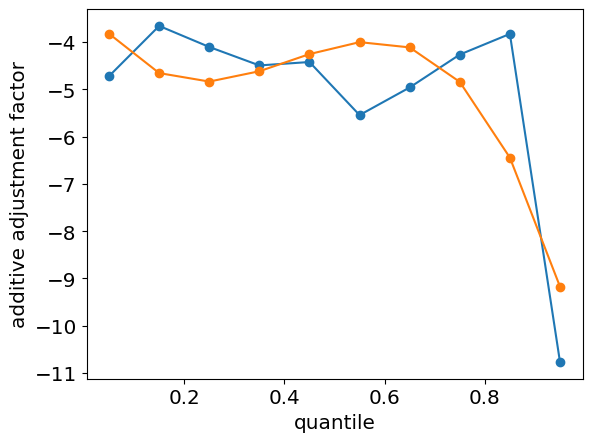

In [46]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [47]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [48]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

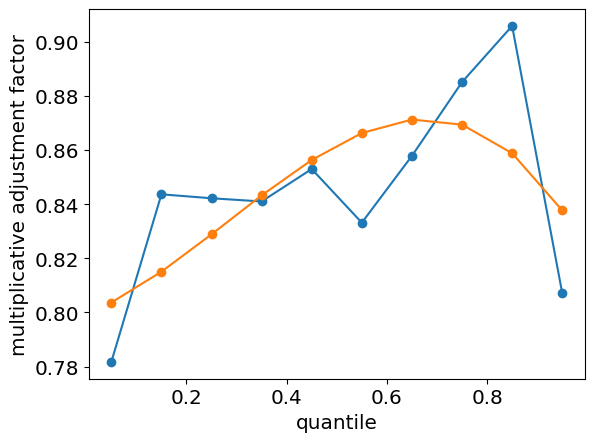

In [49]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [50]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [51]:
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [52]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [53]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: -0.06
Location parameter: 28.56
Scale parameter: 7.27


#### Multiplicative

In [54]:
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [55]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [56]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: -0.08
Location parameter: 28.52
Scale parameter: 7.18


## Comparison

In [57]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

In [58]:
xmax = np.max([da_model_detrended_stacked.values.max(), da_obs_detrended.values.max()]) + 1
xmin = np.min([da_model_detrended_stacked.values.min(), da_obs_detrended.values.min()]) - 1

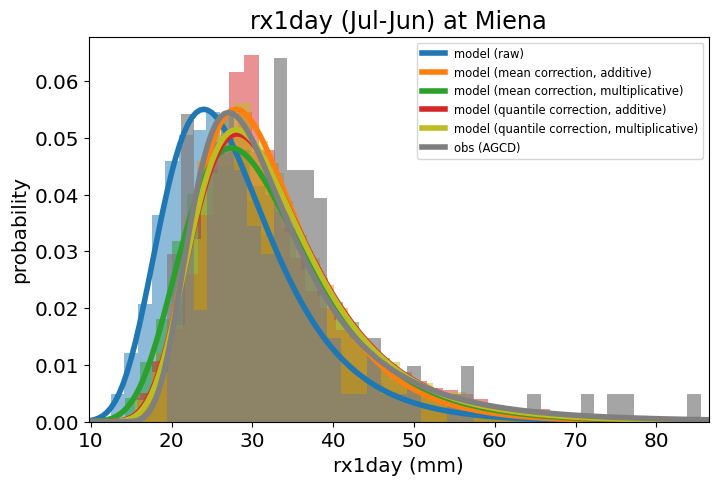

In [66]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(5, 120, 0.5)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('rx1day (mm)')
plt.ylabel('probability')
plt.title(f'rx1day (Jul-Jun) at {location}')

plt.xlim(xmin, xmax)
plt.legend(fontsize='small')
plt.savefig(f'rx1day_{location}_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

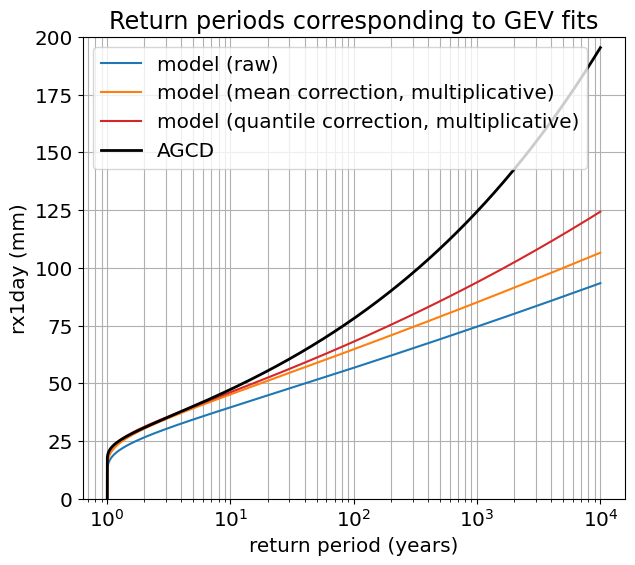

In [72]:
fig = plt.figure(figsize=[7, 6])
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(111)

#ax1.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', label='model (raw)')
return_periods_model_detrended, return_values_model_detrended = stability.return_curve(
    da_model_detrended,
    'gev',
    params=[gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended],
)
ax2.plot(return_periods_model_detrended, return_values_model_detrended, label='model (raw)', color='tab:blue')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_mean_mulc, color='tab:orange', label='model (mean correction, multiplicative)')
return_periods_model_detrended_bc_mean_mulc, return_values_model_detrended_bc_mean_mulc = stability.return_curve(
    da_model_detrended_bc_mean_mulc,
    'gev',
    params=[gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc],
)
ax2.plot(
    return_periods_model_detrended_bc_mean_mulc,
    return_values_model_detrended_bc_mean_mulc,
    label='model (mean correction, multiplicative)',
    color='tab:orange'
)

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_quantile_mulc, color='tab:red', label='model (quantile correction, multiplicative)')
return_periods_model_detrended_bc_quantile_mulc, return_values_model_detrended_bc_quantile_mulc = stability.return_curve(
    da_model_detrended_bc_quantile_mulc,
    'gev',
    params=[gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc],
)
ax2.plot(
    return_periods_model_detrended_bc_quantile_mulc,
    return_values_model_detrended_bc_quantile_mulc,
    label='model (quantile correction, multiplicative)',
    color='tab:red'
)

#ax1.plot(gev_xvals, gev_pdf_obs_detrended, color='black', linewidth=2.0, label='AGCD')
return_periods_obs_detrended, return_values_obs_detrended = stability.return_curve(
    da_obs_detrended,
    'gev',
    params=[gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended],
)
ax2.plot(return_periods_obs_detrended, return_values_obs_detrended, label='AGCD', color='black', linewidth=2.0)

#ax1.grid()
#ax1.set_xlabel('TXx (C)')
#ax1.set_ylabel('probability')
#ax1.axvline(agcd_max, color='0.5', linestyle='--')
#ax1.set_title('(a) GEV fit to data')
#ax1.set_xlim([0, 450])
#ax1.legend()

ax2.legend()
#ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('rx1day (mm)')
ax2.set_title('Return periods corresponding to GEV fits')
ax2.set_ylim([0, 200])
ax2.grid(which='both')
plt.savefig(f'rx1day_{location}_return_curves.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [61]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.23956165
KS p-value: 1.2034534e-06
AD score: 23.419502
AD p-value: 0.001


### Additive - mean correction

KS score: 0.17417154
KS p-value: 0.0010458868
AD score: 8.219606
AD p-value: 0.001


INFO:root:mean: Obs = 33.636634826660206, Model 95% CI =26.611376466401357 to 29.90013493267243
INFO:root:standard deviation: Obs = 11.583695088907392, Model 95% CI =7.236828859066219 to 10.305532453741856
INFO:root:skew: Obs = 1.9837975290430605, Model 95% CI =0.516686246404554 to 1.7530929334553496
INFO:root:kurtosis: Obs = 5.0804636620054335, Model 95% CI =-0.29419642300524346 to 5.0618314122155095
INFO:root:GEV shape: Obs = -0.18530212773463917, Model 95% CI =-0.16568560874218327 to 0.09699848766842921
INFO:root:GEV location: Obs = 28.1941717995234, Model 95% CI =22.804286791879328 to 25.5381072028481
INFO:root:GEV scale: Obs = 6.865476005754465, Model 95% CI =5.693682310629233 to 7.599540735210899
INFO:root:mean: Obs = 33.636634826660206, Bias corrected model 95% CI =30.631188274349284 to 33.69872461675817
INFO:root:standard deviation: Obs = 11.583695088907392, Bias corrected model 95% CI =7.275912878317466 to 10.340130232251342
INFO:root:skew: Obs = 1.9837975290430605, Bias corre

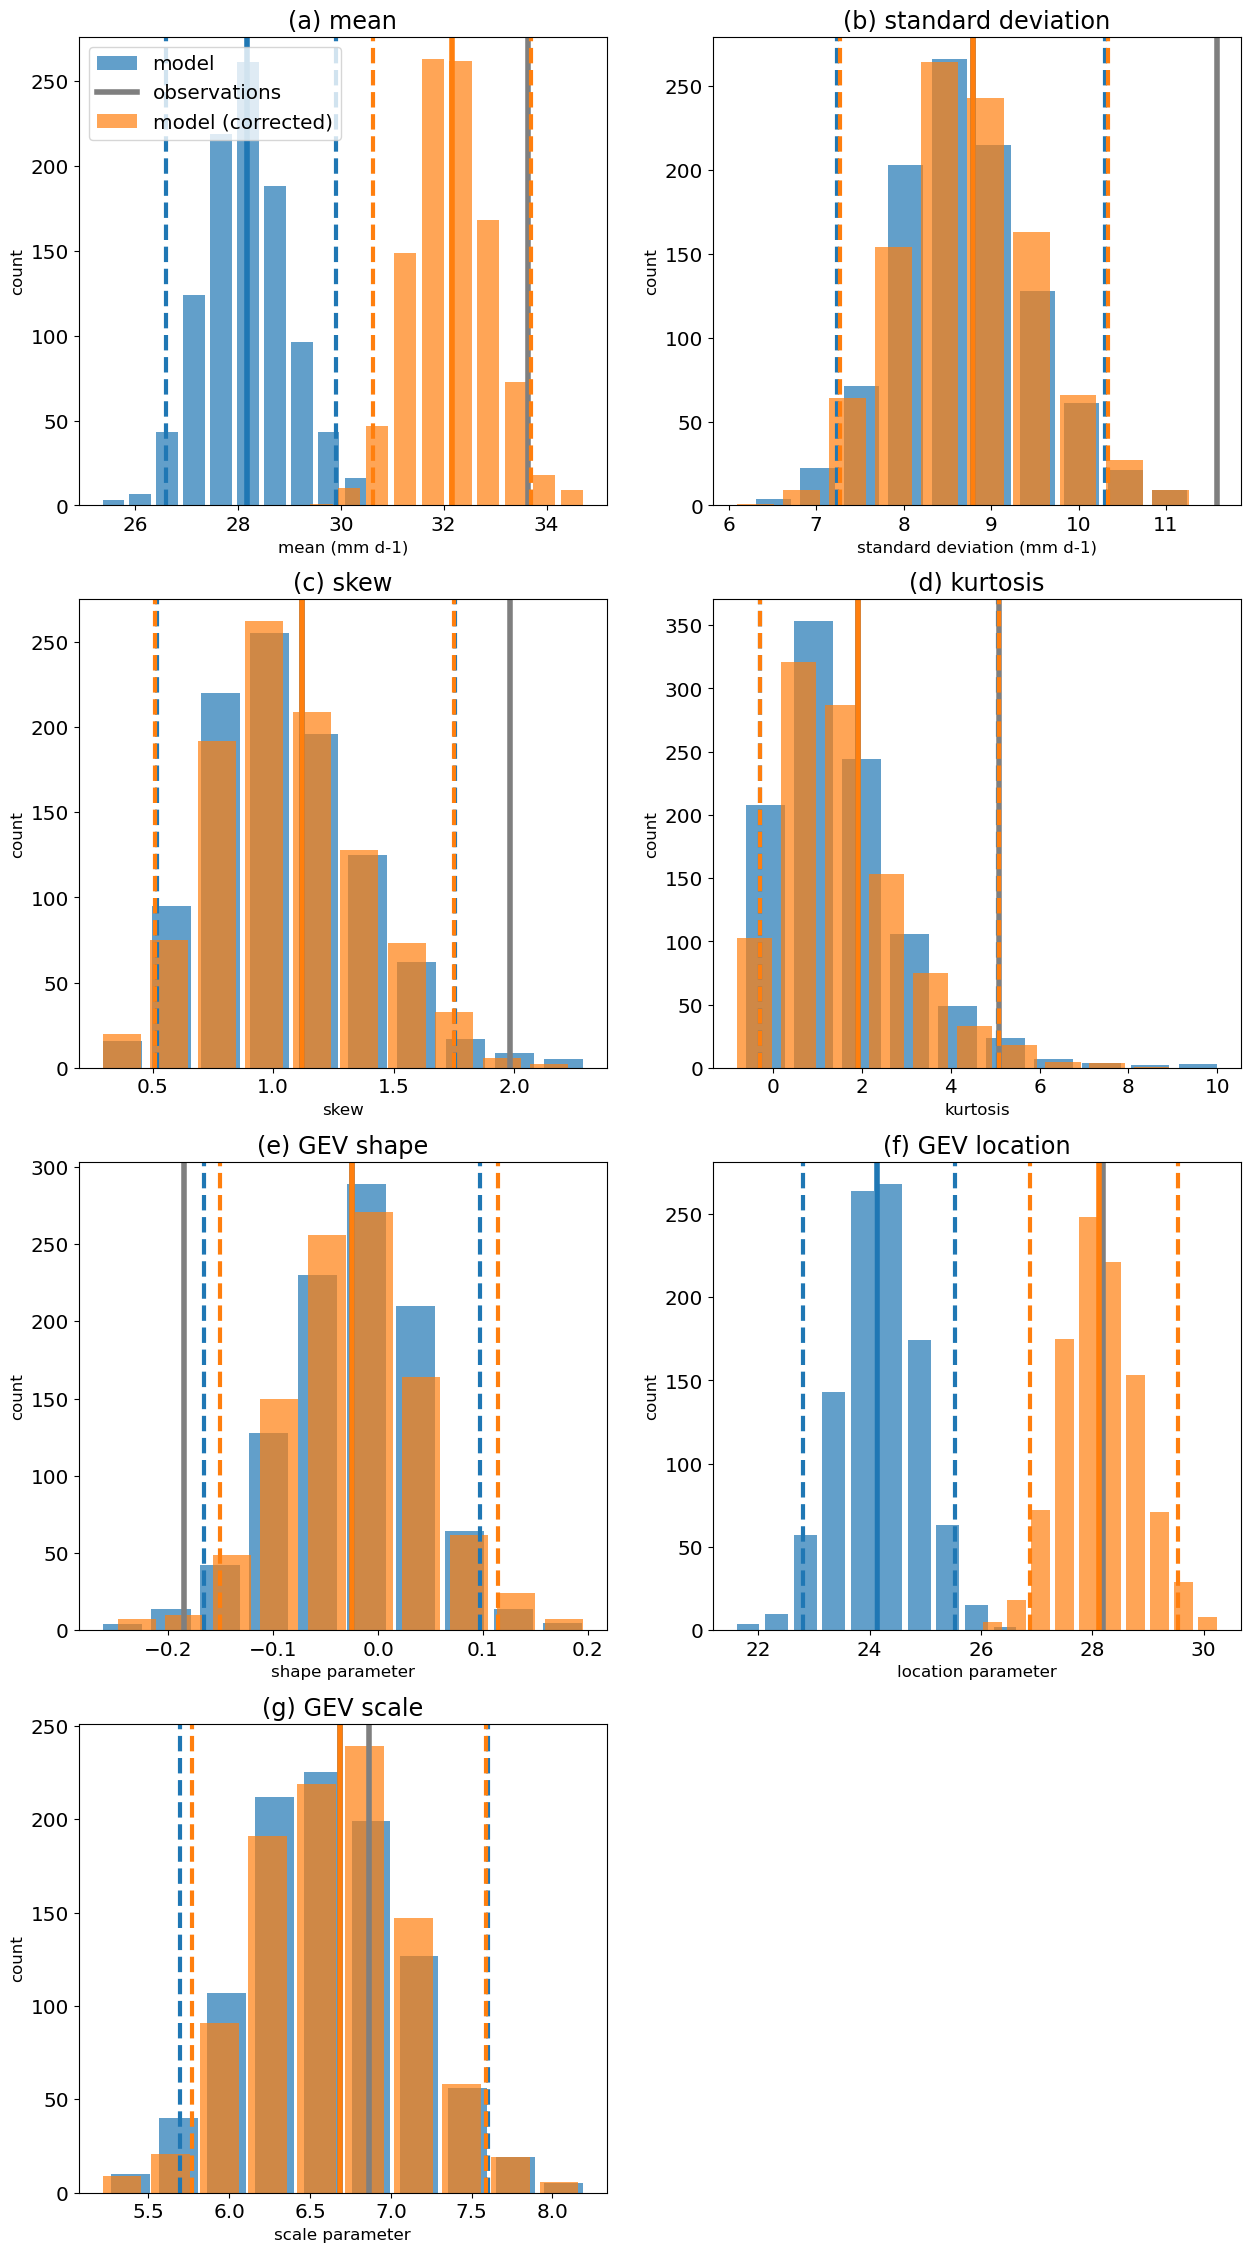

In [62]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.18265107
KS p-value: 0.0004923573
AD score: 9.477354
AD p-value: 0.001


INFO:root:mean: Obs = 33.636634826660206, Model 95% CI =26.731616071867034 to 29.767385821948498
INFO:root:standard deviation: Obs = 11.583695088907392, Model 95% CI =7.2776079537173075 to 10.311627099510162
INFO:root:skew: Obs = 1.9837975290430605, Model 95% CI =0.5119951565307261 to 1.7583817891544866
INFO:root:kurtosis: Obs = 5.0804636620054335, Model 95% CI =-0.2743989764634452 to 4.973750230381195
INFO:root:GEV shape: Obs = -0.18530212773463917, Model 95% CI =-0.145888641406613 to 0.11082576736944386
INFO:root:GEV location: Obs = 28.1941717995234, Model 95% CI =22.870897985111725 to 25.564632168333755
INFO:root:GEV scale: Obs = 6.865476005754465, Model 95% CI =5.767952503874009 to 7.633176963431258
INFO:root:mean: Obs = 33.636634826660206, Bias corrected model 95% CI =30.425760357674093 to 34.041426698911685
INFO:root:standard deviation: Obs = 11.583695088907392, Bias corrected model 95% CI =8.17660405866673 to 11.782974222195072
INFO:root:skew: Obs = 1.9837975290430605, Bias corr

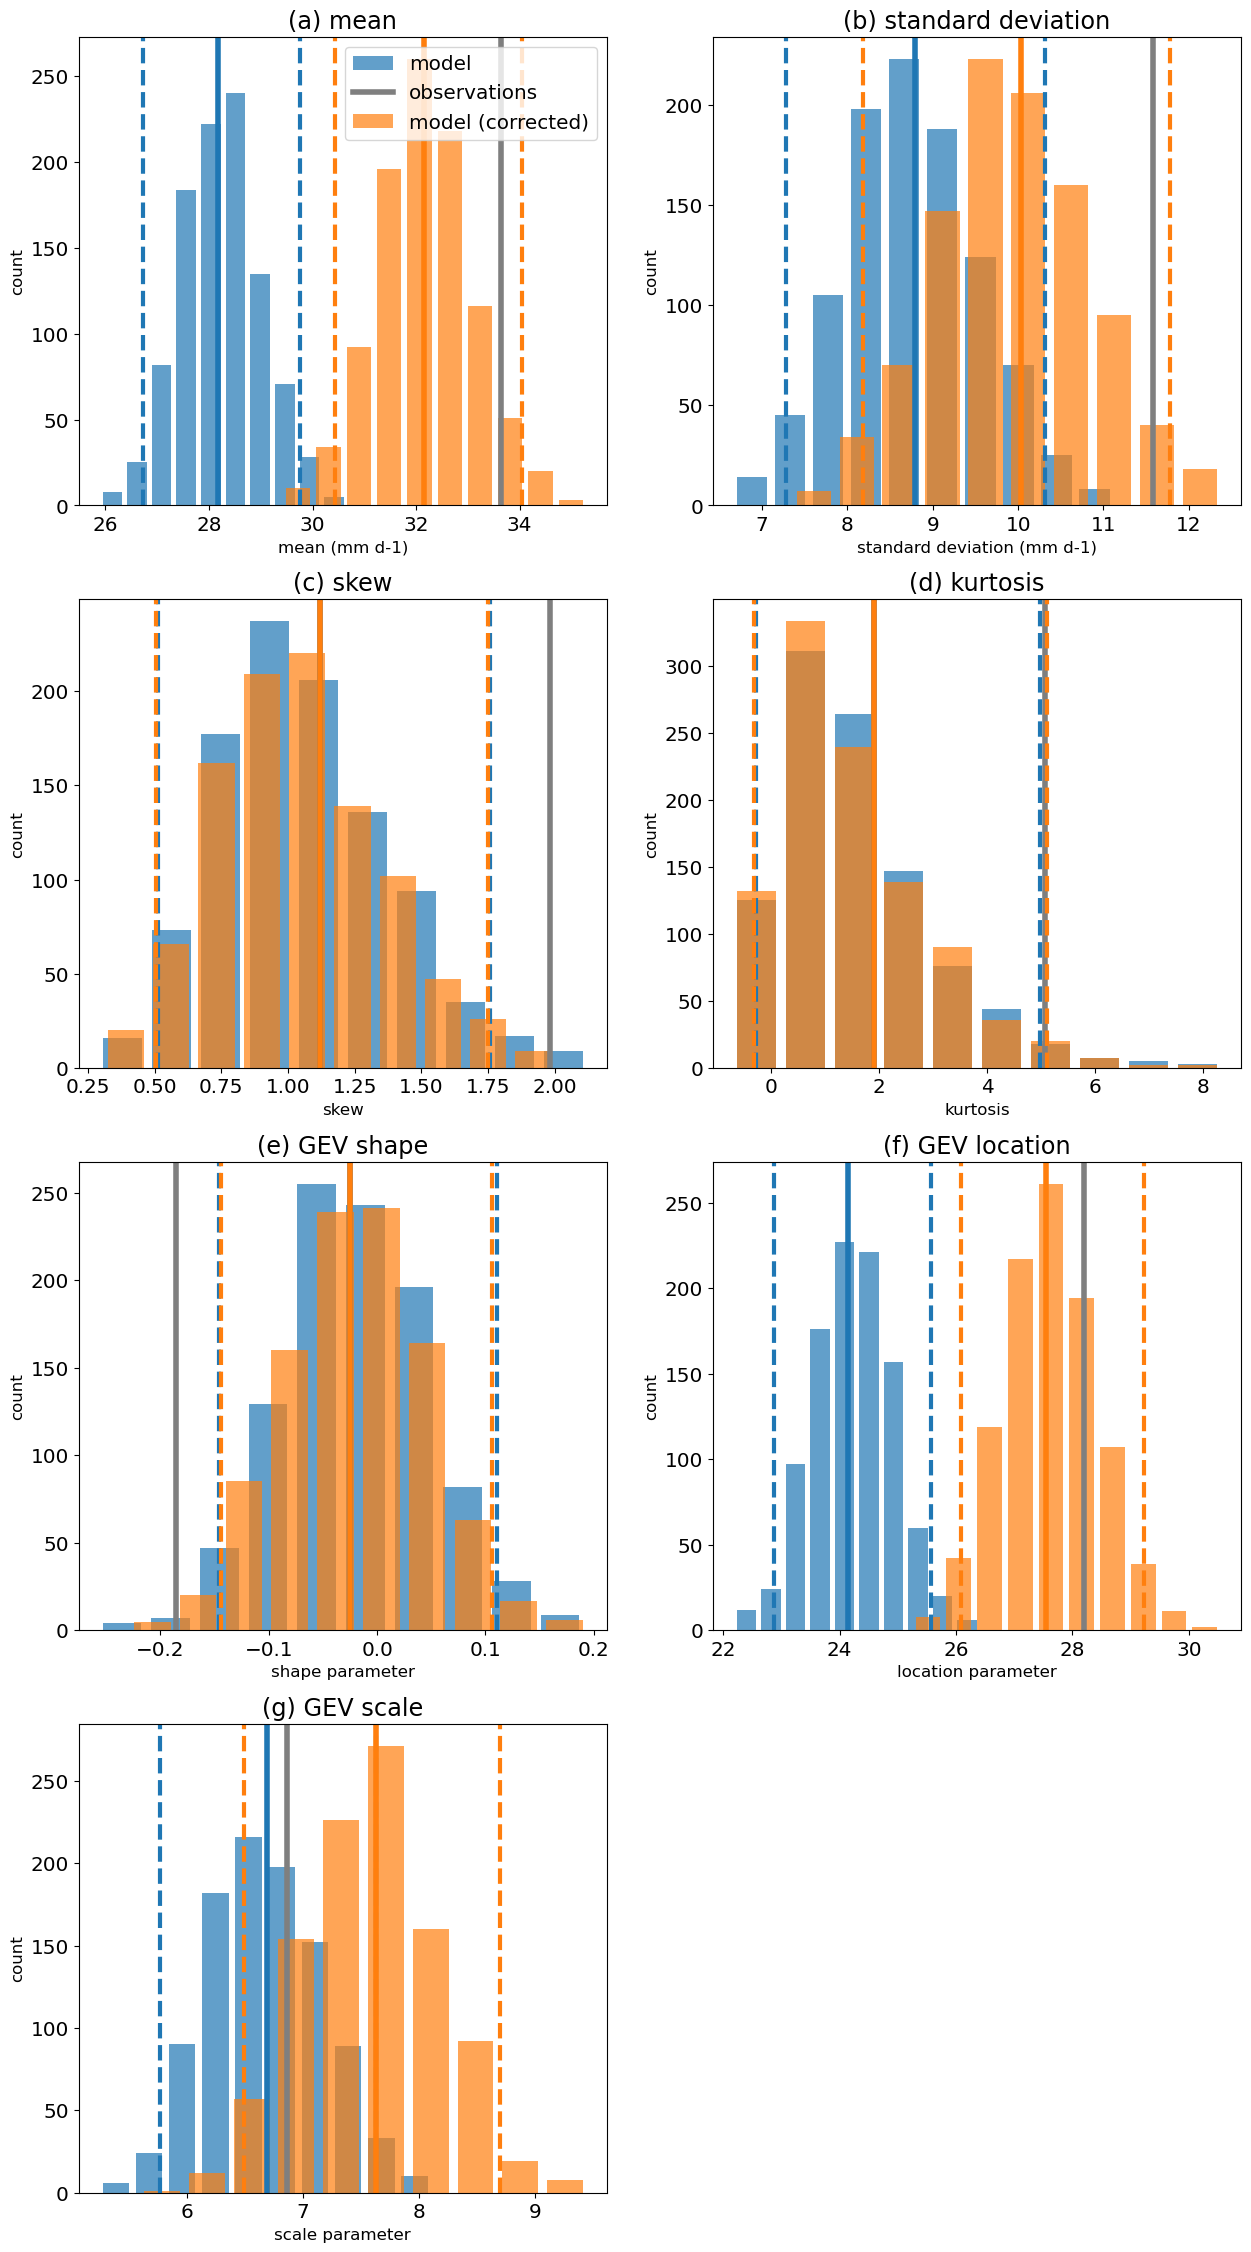

In [63]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.1696881
KS p-value: 0.0015348869
AD score: 4.8781447
AD p-value: 0.0038372544


INFO:root:mean: Obs = 33.636634826660206, Model 95% CI =26.77434548912673 to 29.689208010651754
INFO:root:standard deviation: Obs = 11.583695088907392, Model 95% CI =7.359864738758957 to 10.293975335615242
INFO:root:skew: Obs = 1.9837975290430605, Model 95% CI =0.4983707336602637 to 1.7334268138769653
INFO:root:kurtosis: Obs = 5.0804636620054335, Model 95% CI =-0.35194762732150353 to 5.175772973117988
INFO:root:GEV shape: Obs = -0.18530212773463917, Model 95% CI =-0.15646635899796335 to 0.11182838710440042
INFO:root:GEV location: Obs = 28.1941717995234, Model 95% CI =22.885422960304 to 25.528485341293734
INFO:root:GEV scale: Obs = 6.865476005754465, Model 95% CI =5.695010263005188 to 7.605615857680386
INFO:root:mean: Obs = 33.636634826660206, Bias corrected model 95% CI =31.564188233867043 to 35.0339434345997
INFO:root:standard deviation: Obs = 11.583695088907392, Bias corrected model 95% CI =8.401566175257075 to 12.101670385218691
INFO:root:skew: Obs = 1.9837975290430605, Bias correct

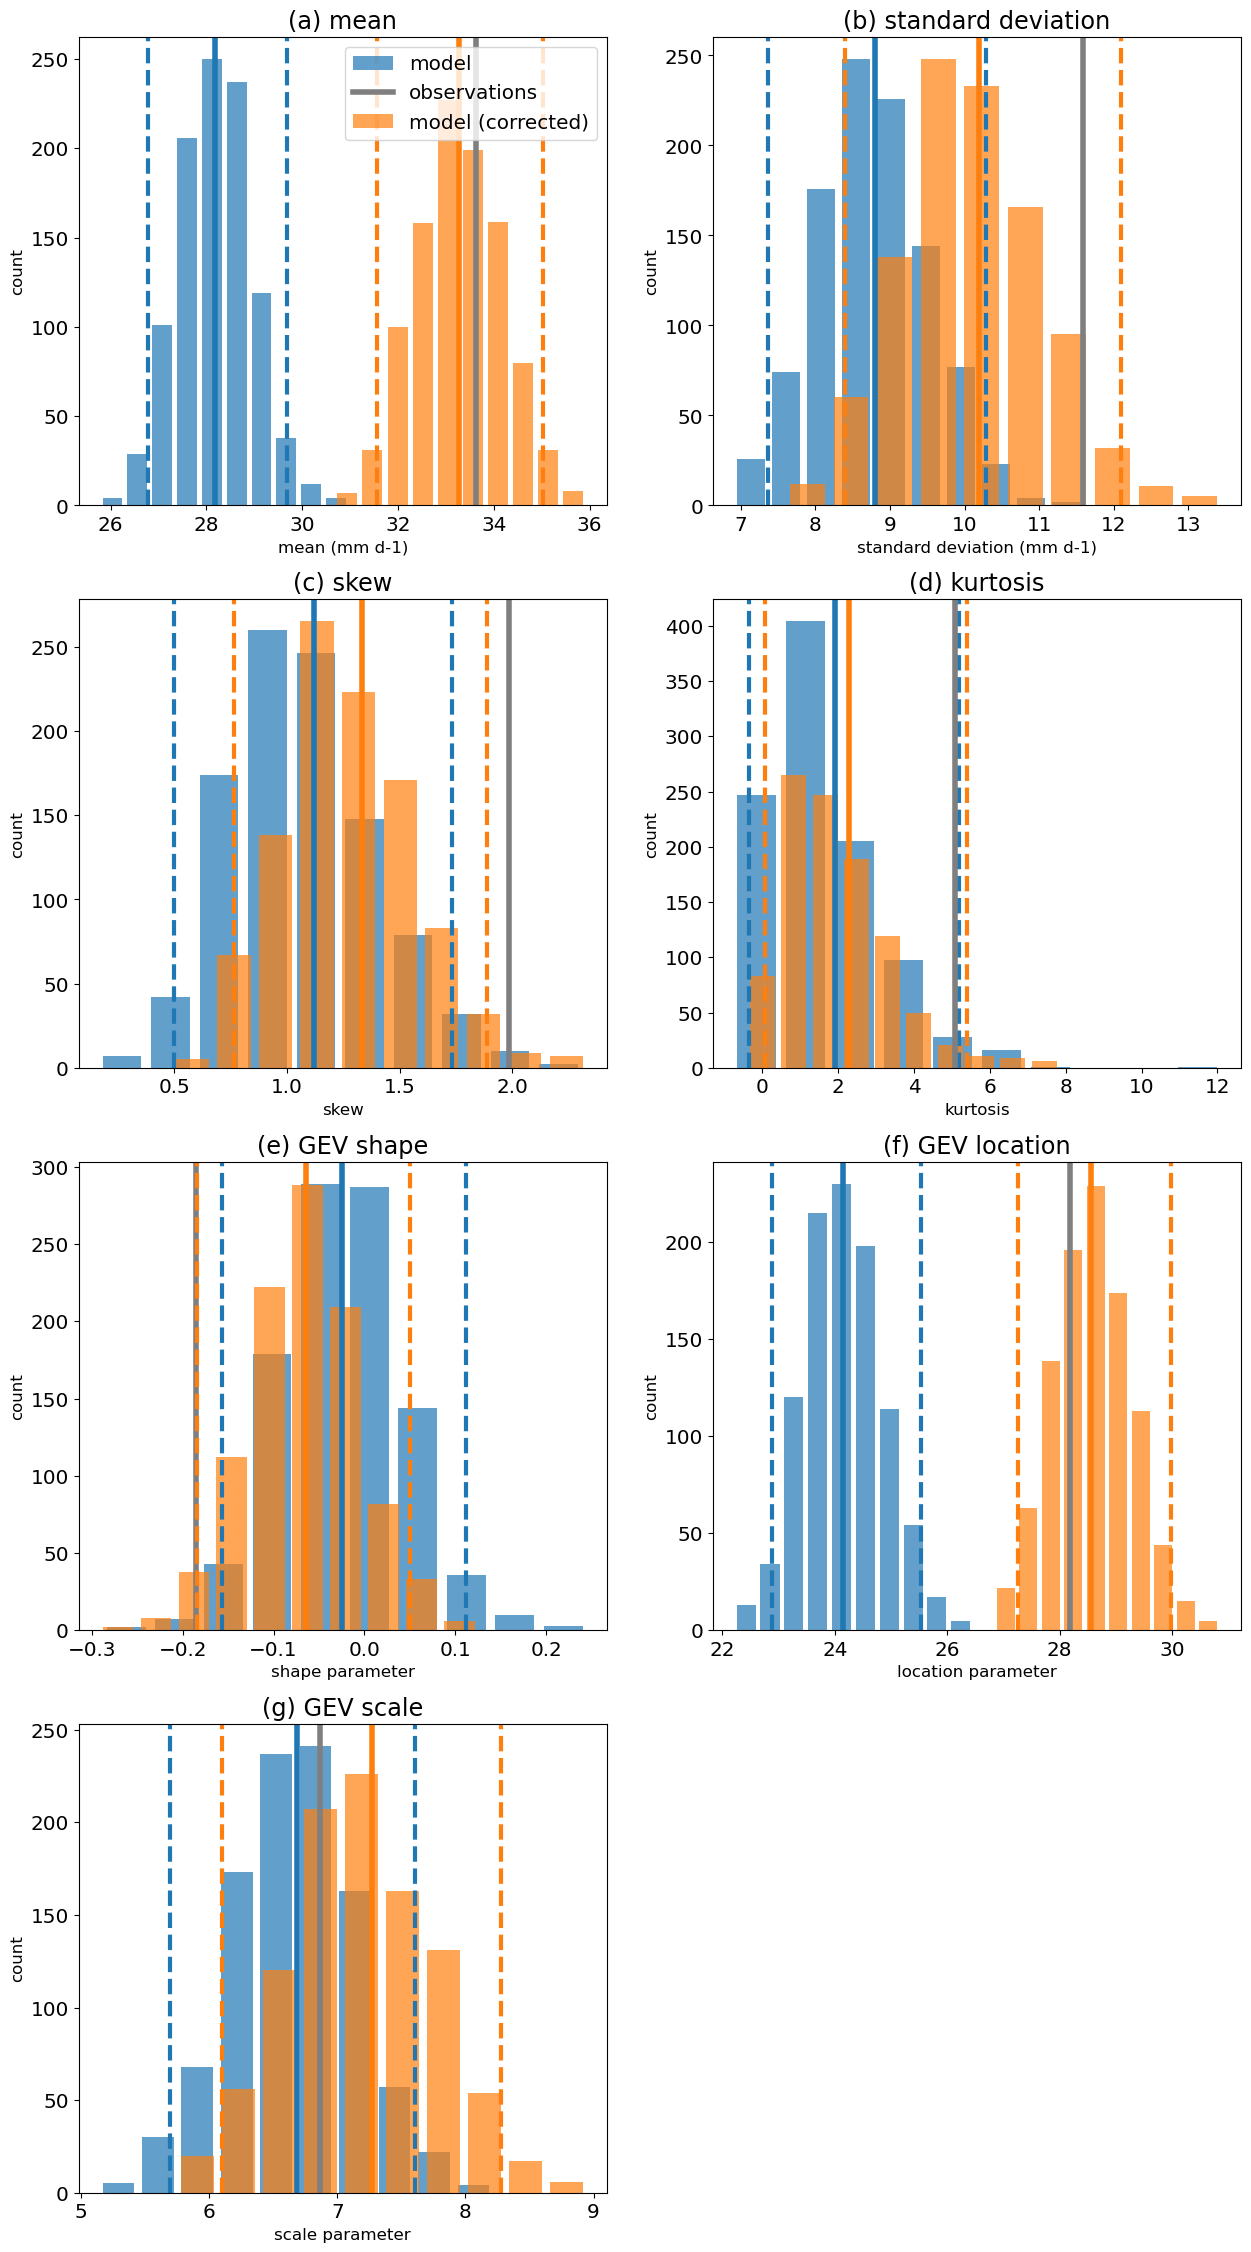

In [64]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.16042885
KS p-value: 0.003281962
AD score: 4.620938
AD p-value: 0.004757004


INFO:root:mean: Obs = 33.636634826660206, Model 95% CI =26.70321288507185 to 29.754057549743226
INFO:root:standard deviation: Obs = 11.583695088907392, Model 95% CI =7.283791042005824 to 10.299646827388282
INFO:root:skew: Obs = 1.9837975290430605, Model 95% CI =0.5265735106130263 to 1.718996137070216
INFO:root:kurtosis: Obs = 5.0804636620054335, Model 95% CI =-0.2824476436287272 to 4.837447683760422
INFO:root:GEV shape: Obs = -0.18530212773463917, Model 95% CI =-0.154291951849417 to 0.10855498064381479
INFO:root:GEV location: Obs = 28.1941717995234, Model 95% CI =22.900083470931524 to 25.591657397237658
INFO:root:GEV scale: Obs = 6.865476005754465, Model 95% CI =5.690537022997663 to 7.576298202016525
INFO:root:mean: Obs = 33.636634826660206, Bias corrected model 95% CI =31.721184189427106 to 35.00058348207768
INFO:root:standard deviation: Obs = 11.583695088907392, Bias corrected model 95% CI =8.24862625648881 to 12.212001939146266
INFO:root:skew: Obs = 1.9837975290430605, Bias correcte

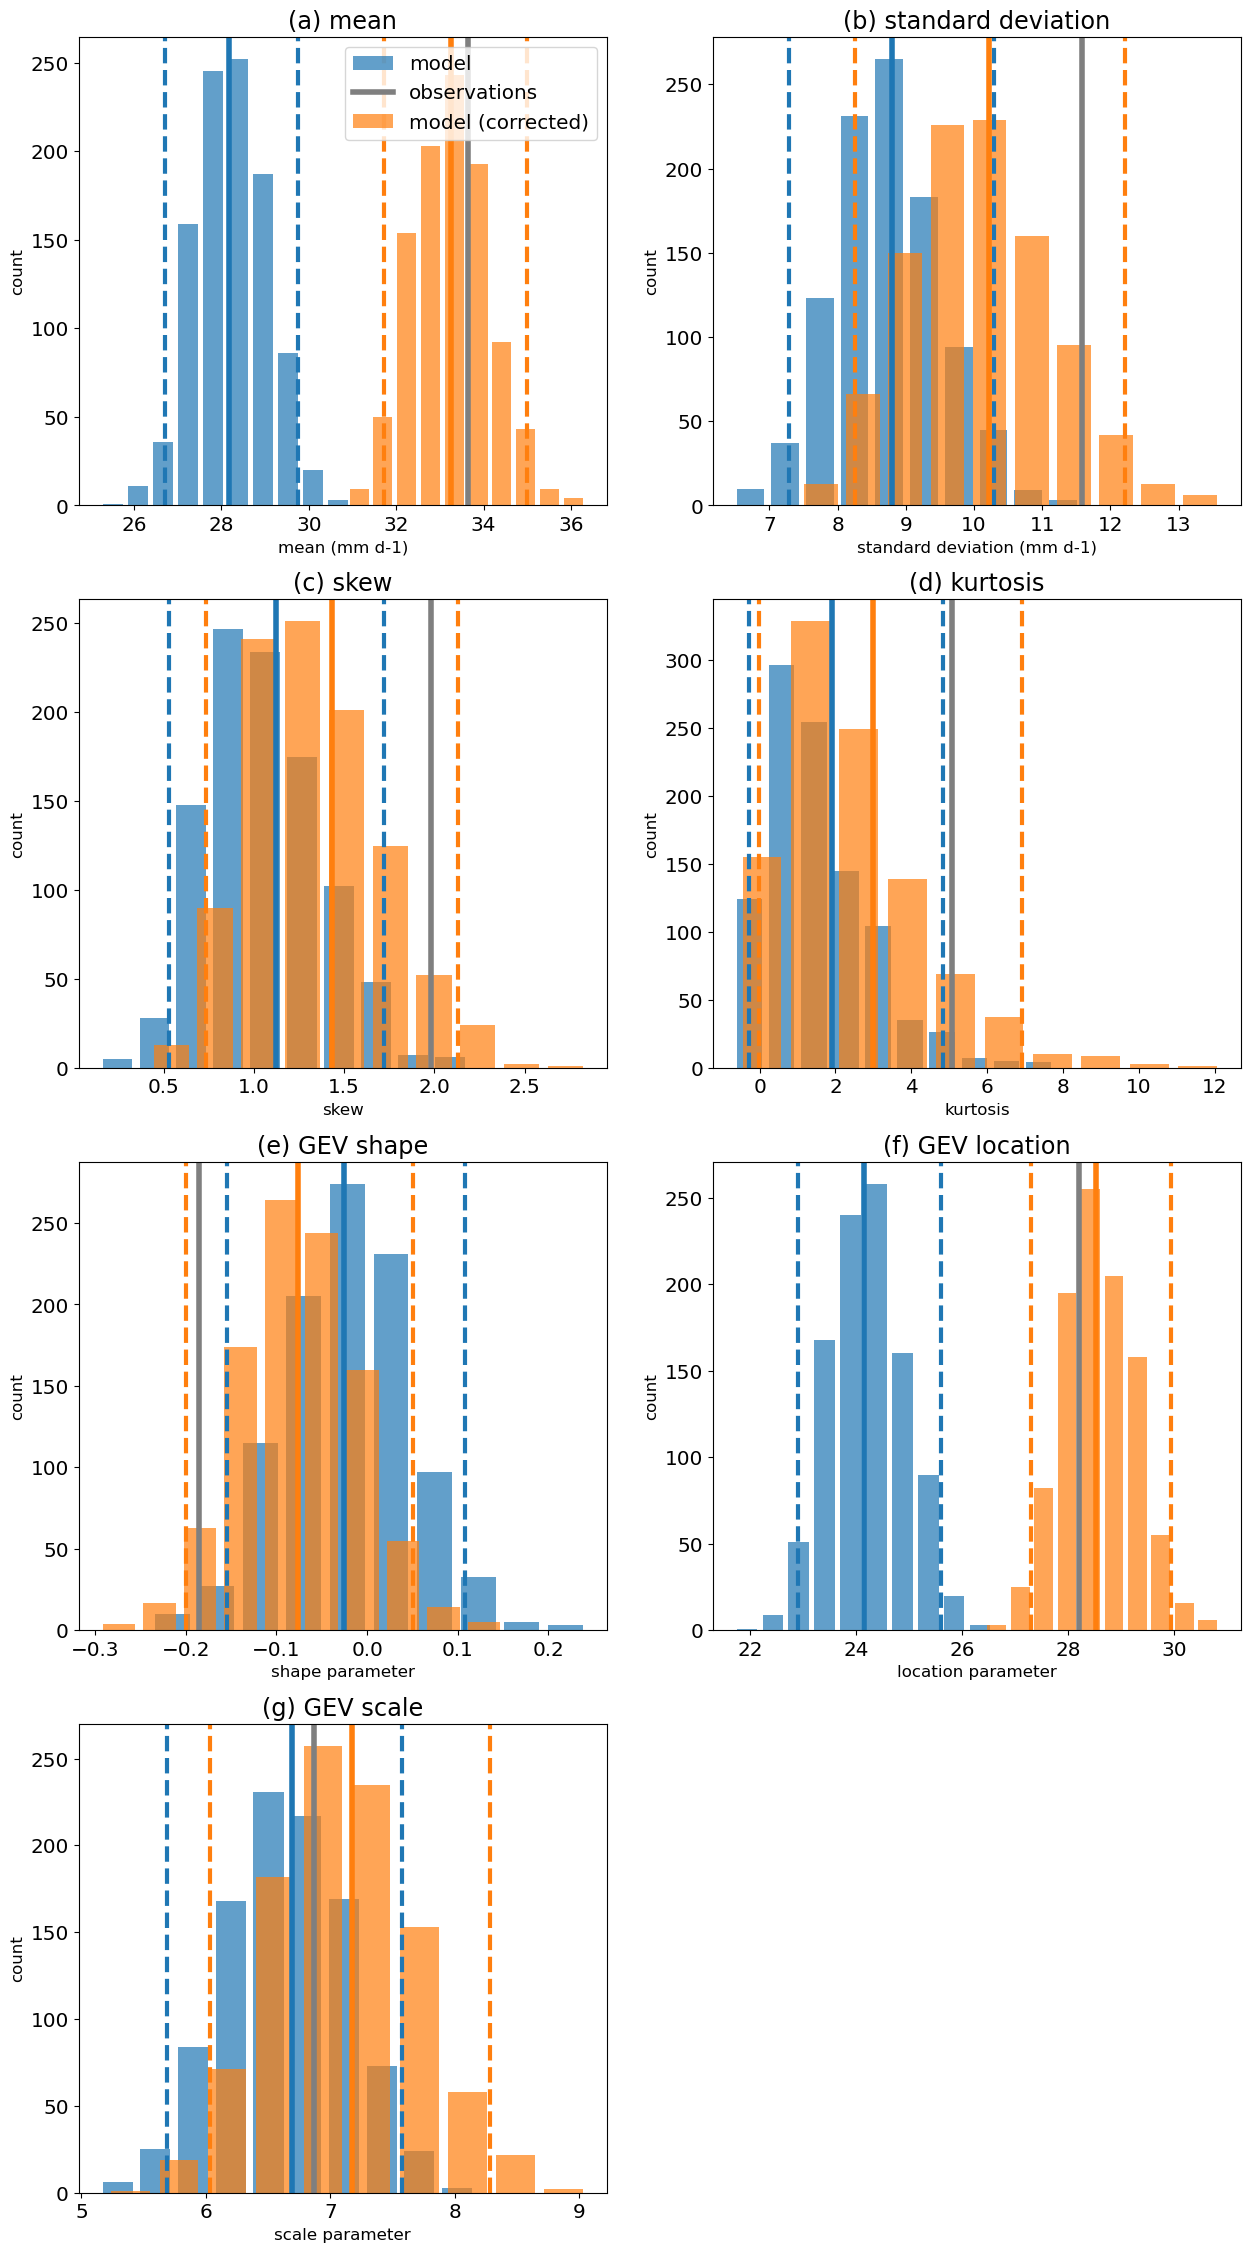

In [65]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())